<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Описание проекта

# Восстановление золота из руды

Компания "Цифры" разрабатывает решения для эффективной работы промышленных предприятий.Для неё нужно подготовить прототип модели машинного обучения.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки.<br>
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Данные находятся в трёх файлах:

"gold_recovery_train_new.csv" — обучающая выборка;<br>
"gold_recovery_test_new.csv" — тестовая выборка;<br>
"gold_recovery_full_new.csv" — исходные данные.<br>
Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.<br>
<br>

В нашем распоряжении сырые данные. Прежде чем приступить к построению модели, проверим по нашему плану их на корректность.
<br><br>
План работ.
>1. __Подготовить данные__ <br>
   1.1. Открыть файлы и изучить их.<br>
   1.2. Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найдти MAE между вашими расчётами и значением признака. Опишисать выводы.<br>
 1.3. Проанализировать признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?<br>
 1.4. Провести предобработку данных.<br><br>
> 2. __Проанализировать данные__<br>
 2.1. Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Описать выводы.<br>
 2.2.  Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.<br>
 2.3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.<br> <br>
> 3. __Построить модель__<br>
 3.1. Напишисать функцию для вычисления итоговой sMAPE.<br>
 3.2. Обучить разные модели и оцените их качество кросс-валидацией. Выберать лучшую модель и проверить её на тестовой выборке. Описать выводы.<br>

Технологический процесс<br>
* **Rougher feed** — исходное сырье<br>
* **Rougher additions** (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant<br><br>
  
    - Xanthate **— ксантогенат (промотер, или активатор флотации);<br>
    - Sulphate — сульфат (на данном производстве сульфид натрия);<br>
    - Depressant — депрессант (силикат натрия).<br>
<br>  
* **Rougher process** (англ. «грубый процесс») — флотация<br>
* **Rougher tails** — отвальные хвосты<br>
* **Float banks** — флотационная установка<br>
* **Cleaner process** — очистка<br>
* **Rougher Au** — черновой концентрат золота<br>
* **Final Au** — финальный концентрат золота<br><br>
__Параметры этапов__<br><br>
* **air amount** — объём воздуха<br>
* **fluid levels** — уровень жидкости<br>
* **feed size** — размер гранул сырья<br>
* **feed rate** — скорость подачи<br>

__Цель проекта__<br>
    Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата __rougher.output.recovery__;
- эффективность обогащения финального концентрата __final.output.recovery__.

## Подготовка данных

In [1]:
#импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import RandomState

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

from tqdm import tqdm

In [2]:
#Выгрузка данных для локальной работы, так и для проверки
try:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    data_train = pd.read_csv('gold_recovery_train_new.csv')
    data_test = pd.read_csv('gold_recovery_test_new.csv')
    data_full = pd.read_csv('gold_recovery_full_new.csv')

In [3]:
# Функция для отображения общей информации
def review(df):
    info = \
    display(df.head()),
    df.info(),
    print()
    print('-' * 40, '\n', 
          'Количество дубликатов:',df.duplicated().sum(),
          '\n',
         'Количество пропусков:', df.isna().sum().sum(),
          '\n', '-' * 39)

In [4]:
data_train.name = 'Обучающая выборка'
data_test.name = 'Тестовая выборка'
data_full.name = 'Исходные данные'
 
data_list = [data_train, data_test, data_full]

In [5]:
for df in data_list:
    print()
    print(f'{df.name}')
    review(df)


Обучающая выборка


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [6]:
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M')
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%d %H:%M')

In [8]:
print(f'\nТип данных после изменения: {data_train.date.dtype}')


Тип данных после изменения: datetime64[ns]


In [9]:
def missing_values(data):
    m = (
        data.isna()
        .sum()
        .rename('missing_count')
        .to_frame()
        .join(df.isna().mean().rename('missing_ratio').to_frame().round(4)*100)
        .sort_values(by='missing_count', ascending=False).head()
        .loc[lambda x: x['missing_count'] > 0]
    )
    return m

In [10]:
for df in data_list:
    print(f'>>>>>>>>> {df.name} <<<<<<<<<<<')
    print(f'Объем данных: {df.shape}')
    print()

    print('Количество пропусков:')
    display(missing_values(df))
    print()

>>>>>>>>> Обучающая выборка <<<<<<<<<<<
Объем данных: (14149, 87)

Количество пропусков:


,missing_count,missing_ratio
secondary_cleaner.output.tail_sol,1605,11.34
rougher.state.floatbank10_e_air,436,3.08
rougher.input.floatbank11_xanthate,428,3.02
primary_cleaner.output.concentrate_sol,286,2.02
secondary_cleaner.state.floatbank2_a_air,217,1.53



>>>>>>>>> Тестовая выборка <<<<<<<<<<<
Объем данных: (5290, 53)

Количество пропусков:


,missing_count,missing_ratio
rougher.input.floatbank11_xanthate,25,0.47
rougher.input.feed_sol,21,0.40
secondary_cleaner.state.floatbank3_a_air,9,0.17
rougher.input.floatbank11_sulfate,8,0.15
primary_cleaner.input.depressant,5,0.09



>>>>>>>>> Исходные данные <<<<<<<<<<<
Объем данных: (19439, 87)

Количество пропусков:


,missing_count,missing_ratio
secondary_cleaner.output.tail_sol,1748,8.99
rougher.input.floatbank11_xanthate,453,2.33
rougher.state.floatbank10_e_air,436,2.24
primary_cleaner.output.concentrate_sol,370,1.90
secondary_cleaner.state.floatbank2_a_air,220,1.13


**Вывод**

В нашем распоряжении 14149 данных для обучения, и 5290 данных для теста.

Количество данных в датасетах корректное 14149 + 5290 = 19439 (исходный full датасет)

Пропуски в данных у нас есть, и больше всего их в обучающем датасете.

Также преобразовали дату, чтобы делать интересные срезы данных.

**Расчёт эффективности<br>**
Нам нужно смоделировать процесс восстановления золота из золотосодержащей руды. 
Эффективность обогащения рассчитывается по формуле
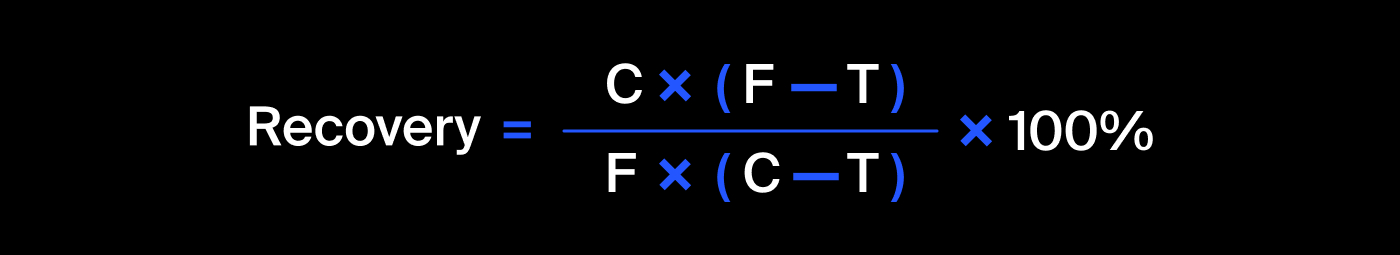
где:<br>
C — доля золота в концентрате после флотации/очистки;<br>
F — доля золота в сырье/концентрате до флотации/очистки;<br>
T — доля золота в отвальных хвостах после флотации/очистки.<br>
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

In [11]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']
recovery = (C * (F - T)) / (F * (C - T)) * 100

In [12]:
print('MAE: ', 
      mean_absolute_error(data_train['rougher.output.recovery'], recovery))

MAE:  9.73512347450521e-15


MAE - средний модуль разности, и показывает как сильно предсказания в среднем отличаются от истинных значений. Полученное значение мало, а значит расчеты верны.

**Проанализируем признаки, недоступные в тестовой выборке.**

In [13]:
missed_signs = set(data_train.columns) - set(data_test.columns)
print(missed_signs)
print('\nКоличество отсутствующих признаков -', len(missed_signs))

{'primary_cleaner.output.tail_au', 'final.output.tail_pb', 'final.output.concentrate_ag', 'rougher.output.tail_sol', 'final.output.recovery', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_sol', 'rougher.output.concentrate_pb', 'rougher.output.tail_pb', 'rougher.output.recovery', 'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'final.output.tail_sol', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.tail_ag', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.tail_au', 'final.output.concentrate_pb', 'primary_cleaner.output.concentrate_ag', 'secondary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'final.output.tail_au', 'final.output.tail_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_pb', 'final.output.concentrate_sol', 'primary_cleaner.output.concentrate_pb', 'rougher.

В тестовой выборки в том числе отсутствуют целевые признаки rougher.output.recovery и final.output.recovery, которые будут нужны для расчета метрики качества. Добавим их в тестовую выборку, используя метод merge, в качестве индексов используем колонку date (данные индексируются датой и временем получения информации)

***Отсутствие признаков можно обьяснить тем, что они замеряются и/или рассчитываются значительно позже.***

In [14]:
data_test = data_test.merge(data_full.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on='date')

In [15]:
# Соседние по времени параметры часто похожи
data_test = data_test.ffill(axis=0)
data_train = data_train.ffill(axis=0)
data_full = data_full.ffill(axis=0)

In [16]:
print('Пропуски в данных')
print(f'Тестовая выборка: {data_test.isna().sum().sum()}')
print(f'Обучающая выборка: {data_train.isna().sum().sum()}')
print(f'Исходные данные: {data_full.isna().sum().sum()}')

Пропуски в данных
Тестовая выборка: 0
Обучающая выборка: 0
Исходные данные: 0


В завершающем шаге предобработки данных считаю нужным удалить колонку date, как не информативную для дальнейшего обучения модели.

In [17]:
data_train = data_train.drop('date', axis=1)
data_test = data_test.drop('date', axis=1)

Вывод
В данных:

- Был изменен тип данных для колонки date с object на datetime. В остальных признаках типы данных соответствуют содержимому.

- Пропуски в датасетах (тренировочная выборки и тестовая) были заполнены значениями предшествующими по времени (Так как в условии задачи сказано, что : "Соседние по времени параметры часто похожи").

- Проверена правильность расчета эффективности обогащения. МАЕ равно предельно малому значению (отличие предсказаний от истинных значений).

- В сравнение с тренировчной выборкой в тестовой отсутствуют 34 значения, это может быть связано с тем, что они замеряются и/или рассчитываются значительно позже.

- В тестовую выборку были добавлены целевые признаки (rougher.output.recovery, final.output.recovery), которые будут необходимы в дальнейшем для рассчета итоговой метрики качества.

- Колонка date была удалена как не информативна для дальнейшего обучения модели.

## Анализ данных

**Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки**

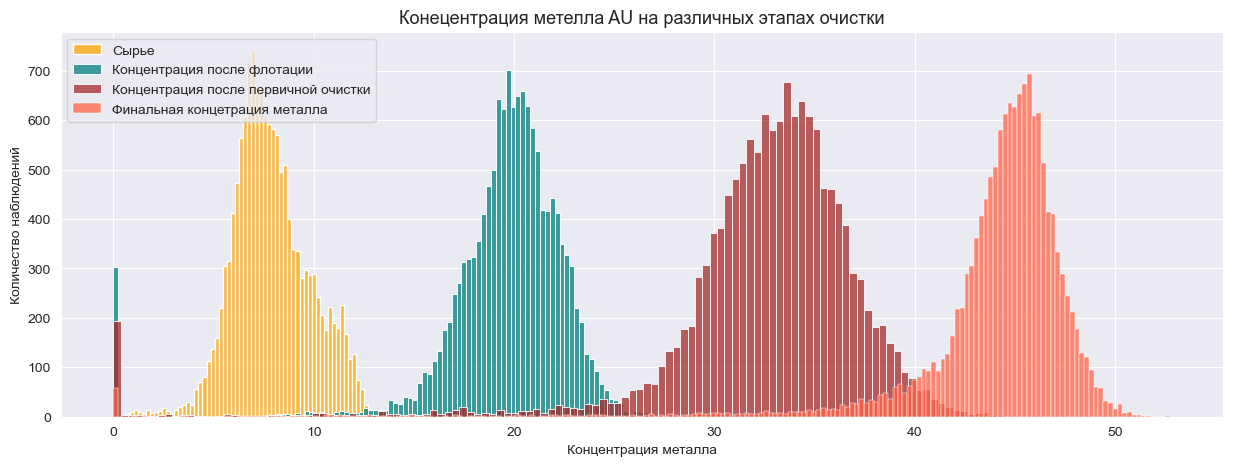

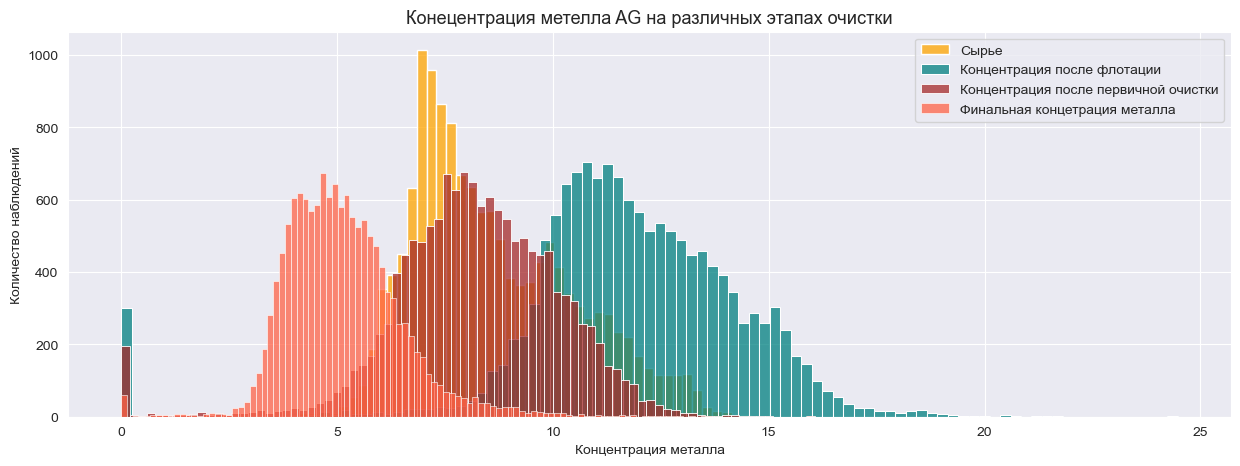

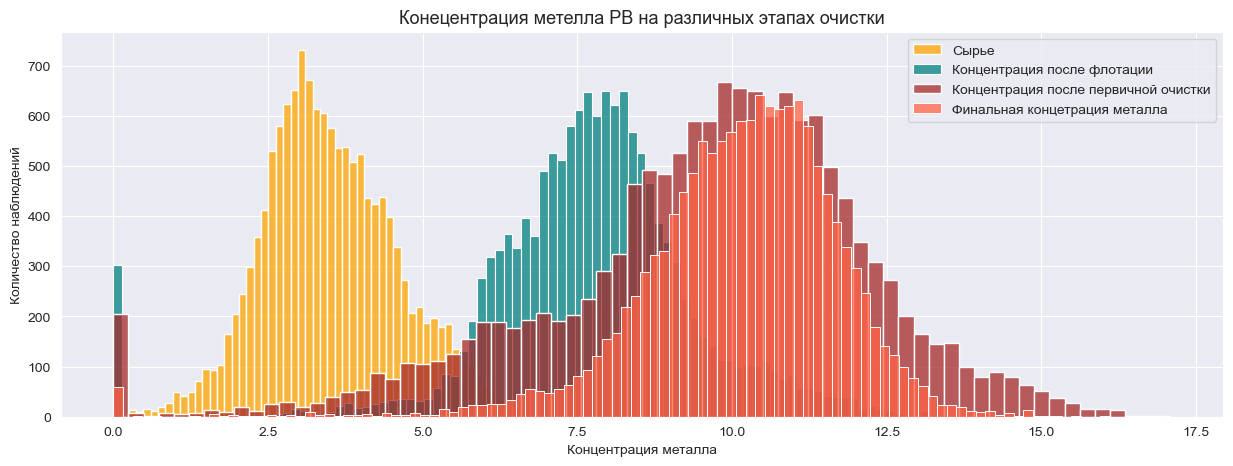

In [18]:
for metal in ['au', 'ag', 'pb']:
    plt.figure(figsize=[15, 5])
    sns.set_style('darkgrid')
    plt.title(
        f'Конецентрация метелла {metal.upper()} на различных этапах очистки', fontsize=13)
    sns.histplot(data_train[f'rougher.input.feed_{metal}'],
                 color='orange',
                 label='Сырье')
    sns.histplot(data_train[f'rougher.output.concentrate_{metal}'],
                 color='teal',
                 label='Концентрация после флотации')
    sns.histplot(data_train[f'primary_cleaner.output.concentrate_{metal}'],
                 color='brown',
                 label='Концентрация после первичной очистки')
    sns.histplot(data_train[f'final.output.concentrate_{metal}'],
                 color='tomato',
                 label='Финальная концетрация металла')
    plt.xlabel('Концентрация металла')
    plt.ylabel('Количество наблюдений')
    plt.legend()
plt.show();

**Вывод:**

**Для золота (AU):<br>**
Доля золота на после каждого этапа очитски постепенно увеличивается.

**Для серебра(AG):<br>**
Доля серебра увеличивается на этапе флотации, а затем постепенно уменьшается.

**Для свинца(PB):<br>**
Доля свинца сначала увеличивается на этапе флотации и после первичной очитски, затем остатется примерно на одном уровне.

В данных для каждого металла присутствуют аномалии.

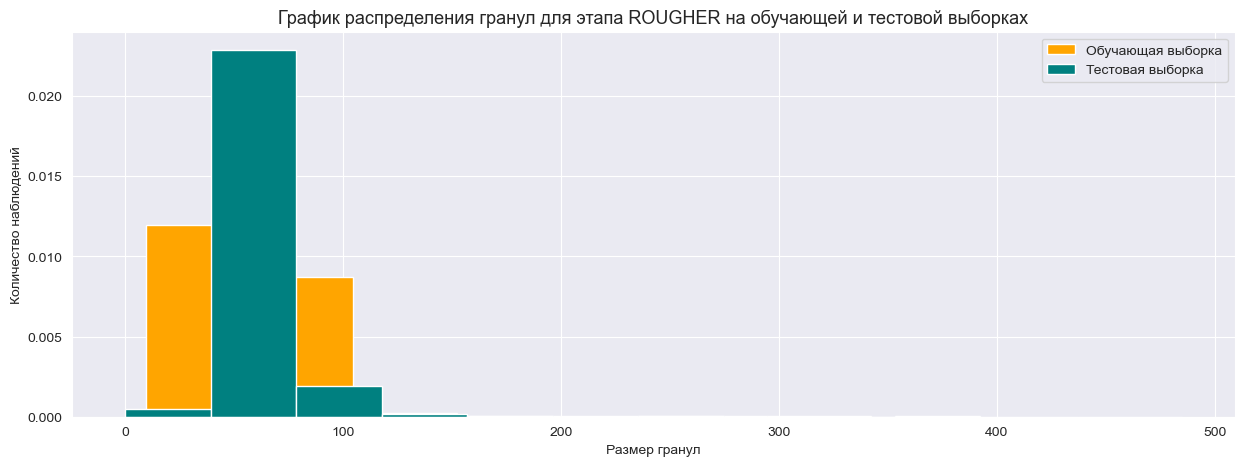

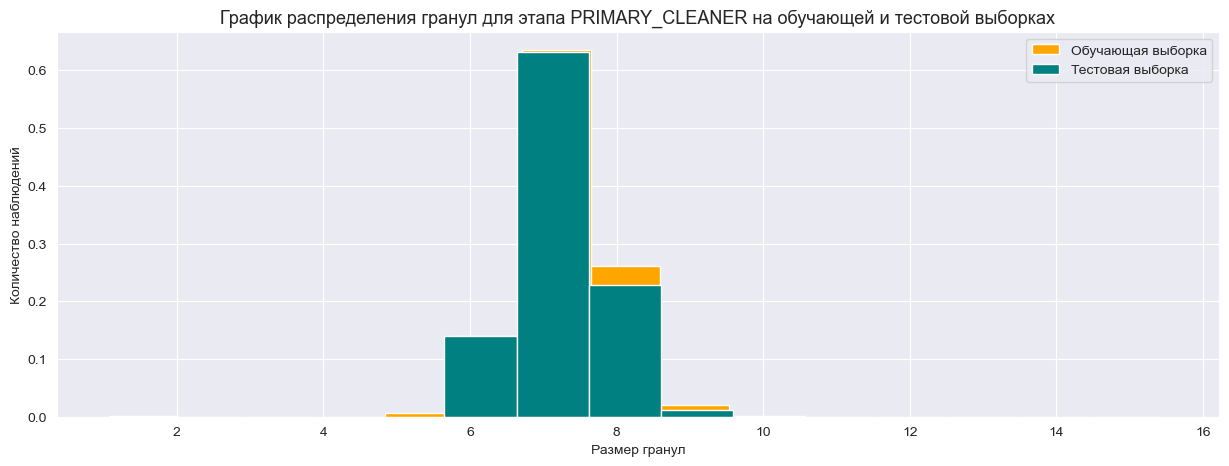

In [19]:
for stage in ['rougher', 'primary_cleaner']:
    plt.figure(figsize=[15, 5])
    sns.set_style('darkgrid')
    plt.title(
        f'График распределения гранул для этапа {stage.upper()} на обучающей и тестовой выборках', fontsize=13)
    plt.hist(data_train[f'{stage}.input.feed_size'], 
             color='orange', 
             label='Обучающая выборка', density=True)
    plt.hist(data_test[f'{stage}.input.feed_size'], 
             color='teal', 
             label='Тестовая выборка', density=True)
    plt.xlabel('Размер гранул')
    plt.ylabel('Количество наблюдений')
    plt.legend()
    plt.show();

**Вывод:**

Для этапа флотации распределение гранул находится примерно в одинаковом диапазоне.

Для этапа первичной очитски разспределение гранул для выборок находится в одном диапазоне, однако есть различия в количестве наблюдений. Так для тренировочной выборки количество наблюдений размера гранул больше, чем для тестовой.

Таким образом, значимых различий между распределениями для выборок не наблюдается.

**Исследуем суммарную концентрацию**

In [20]:
sum_conc_rougher_input = 0
sum_conc_rougher_output = 0
sum_conc_primary_cleaner_output = 0
sum_conc_final_output = 0
for metal in ['au', 'ag', 'pb', 'sol']:
    sum_conc_rougher_input += data_train[f'rougher.input.feed_{metal}']
    sum_conc_rougher_output += data_train[f'rougher.output.concentrate_{metal}']
    sum_conc_final_output += data_train[f'final.output.concentrate_{metal}']

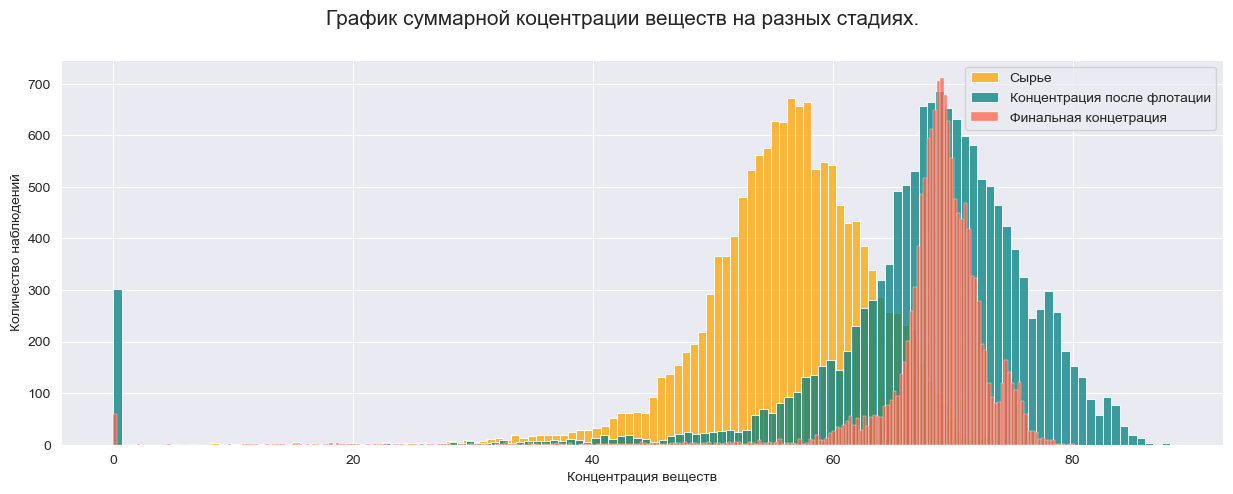

In [21]:
plt.figure(figsize=[15, 5])
plt.suptitle('График суммарной коцентрации веществ на разных стадиях.', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(sum_conc_rougher_input, color='orange', label='Сырье', kde=False)
sns.histplot(sum_conc_rougher_output, color='teal', label='Концентрация после флотации', kde=False)
sns.histplot(sum_conc_final_output, color='tomato', label='Финальная концетрация',kde=False)
plt.xlabel('Концентрация веществ')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

Суммарная концентрация веществ увеличивается к финальному этапу, а диапазон распределения суммарной концентрации веществ уменьшается.


Для финального и этапа флотации для суммарной концентрации веществ присутствуют аномалии ( значения в районе 0). Считаю необходимым удалить аномалии из данных. Аномалии могут негативно повлиять на качество обучения модели.

In [22]:
data_train = data_train[(data_train['rougher.output.concentrate_au'] != 0)
                    & (data_train['rougher.output.concentrate_ag'] != 0) &
                    (data_train['rougher.output.concentrate_pb'] != 0) &
                    (data_train['rougher.output.concentrate_sol'] != 0)]
data_train = data_train[(data_train['final.output.concentrate_au'] != 0)
                    & (data_train['final.output.concentrate_ag'] != 0) &
                    (data_train['final.output.concentrate_pb'] != 0) &
                    (data_train['final.output.concentrate_sol'] != 0)]

data_full = data_full[(data_full['rougher.output.concentrate_au'] != 0)
                  & (data_full['rougher.output.concentrate_ag'] != 0) &
                  (data_full['rougher.output.concentrate_pb'] != 0) &
                  (data_full['rougher.output.concentrate_sol'] != 0)]
data_full = data_full[(data_full['final.output.concentrate_au'] != 0)
                  & (data_full['final.output.concentrate_ag'] != 0) &
                  (data_full['final.output.concentrate_pb'] != 0) &
                  (data_full['final.output.concentrate_sol'] != 0)]

## Модель

**Напишем функцию для вычисления итоговой sMAPE.**

Нам пригодятся формулы метрик качества:

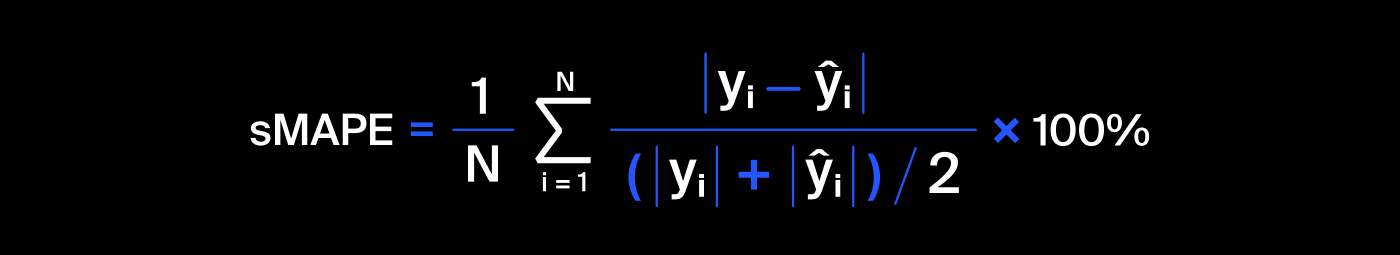

Напишем функцию для вычисления sMape

In [23]:
def get_smape(target, predict):
    smape = (1/len(target))*np.sum((np.abs(target - predict))/
                                   ((np.abs(target)+np.abs(predict))/2))*100
    return smape

In [24]:
smape_scorer = make_scorer(get_smape, greater_is_better = False)

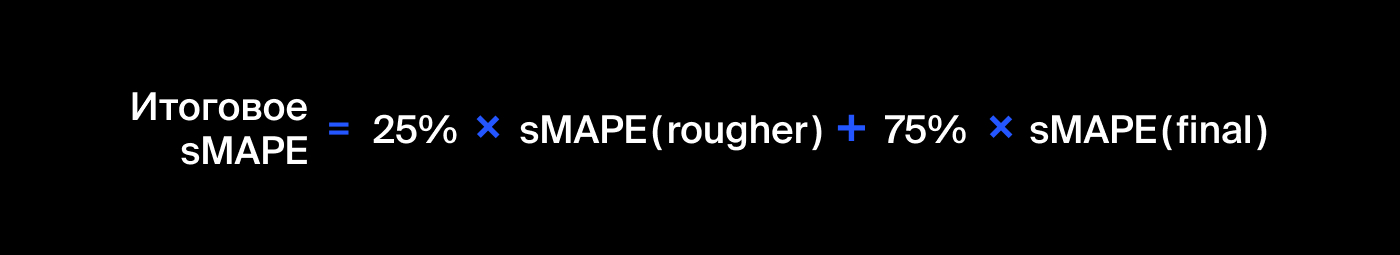

In [25]:
def final_smape(rougher, final):
    final = 0.25*rougher+0.75*final
    return final

Подготовим данные для обучения моделей

Считаю необходимым удаление отсутствующих в тестовой выборке признаков (за исключением целевых признаков) из тренировочной выборки. 

In [26]:
without_target_signs = \
missed_signs - set(['rougher.output.recovery','final.output.recovery'])

In [27]:
print('\nКоличество признаков для удаления из тренировочной выборки -', 
      len(without_target_signs))


Количество признаков для удаления из тренировочной выборки - 32


In [28]:
data_train = data_train.drop(columns=without_target_signs, axis=1)

In [29]:
features_data_train = data_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_rougher_data_train = data_train['rougher.output.recovery']
target_final_data_train = data_train['final.output.recovery']

**Обучим разные модели и оценим их качество кросс-валидацией.**

In [30]:
# Добавим в один словарь для общего обзора
scores = {}

**Модель LinearRegression**

In [31]:
%%time
model_lr_rougher = LinearRegression()
smape_rougher = cross_val_score(model_lr_rougher,
                          features_data_train,
                          target_rougher_data_train,
                          scoring=smape_scorer,
                          cv=5)
final_smape_rougher = sum(smape_rougher) / len(smape_rougher)
model_lr_final = LinearRegression()
smape_final = cross_val_score(model_lr_final,
                        features_data_train,
                        target_final_data_train,
                        scoring=smape_scorer,
                        cv=5)
final_smape_final = sum(smape_final) / len(smape_final)
result_smape = final_smape(final_smape_rougher,final_smape_final)*(-1)
print(result_smape)
scores['LR'] = result_smape

10.059261443482761
CPU times: total: 750 ms
Wall time: 419 ms


In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [33]:
%%time
model_lr_rougher = LinearRegression()
pipe = make_pipeline(StandardScaler(), model_lr_rougher)
smape_rougher = cross_val_score(pipe,
                          features_data_train,
                          target_rougher_data_train,
                          scoring=smape_scorer,
                          cv=5)
final_smape_rougher = sum(smape_rougher) / len(smape_rougher)
model_lr_final = LinearRegression()

pipe = make_pipeline(StandardScaler(), model_lr_final)
smape_final = cross_val_score(pipe,
                        features_data_train,
                        target_final_data_train,
                        scoring=smape_scorer,
                        cv=5)
final_smape_final = sum(smape_final) / len(smape_final)
exemple_result_smape = final_smape(final_smape_rougher,final_smape_final)*(-1)
print(exemple_result_smape)

10.059261443482779
CPU times: total: 1.31 s
Wall time: 724 ms


**Модель DecisionTreeRegressor**

In [34]:
state = np.random.RandomState(12345)

In [35]:
%%time
best_result_dt = 100
for depth in tqdm(range(1, 10, 1)):
    model_dt_rougher = DecisionTreeRegressor(max_depth=depth, random_state=state)
    smape_rougher = cross_val_score(model_dt_rougher,
                              features_data_train,
                              target_rougher_data_train,
                              scoring=smape_scorer,
                              cv=5)
    final_smape_rougher = sum(smape_rougher) / len(smape_rougher)

    model_dt_final = DecisionTreeRegressor(max_depth=depth, random_state=state)
    smape_final = cross_val_score(model_dt_final, 
                                  features_data_train,
                                  target_final_data_train,
                                  scoring=smape_scorer,
                                  cv=5)
    final_smape_final = sum(smape_final) / len(smape_final)
    result_smape = final_smape(final_smape_rougher, final_smape_final)*(-1)
    if result_smape < best_result_dt:
        best_result_dt = result_smape
print(best_result_dt)            
scores['DT'] = best_result_dt

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.53s/it]

8.925785452030949
CPU times: total: 31.8 s
Wall time: 31.8 s


**Модель RandomForestRegressor**

In [36]:
%%time
best_model_rf = 100
for depth in tqdm(range(2,10,2)):
    for est in range(10, 100, 30):
        model_rf_rougher = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=state)
        smape_rougher = cross_val_score(model_rf_rougher,
                                  features_data_train,
                                  target_rougher_data_train,
                                  scoring=smape_scorer,
                                  cv=5)
        final_smape_rougher = sum(smape_rougher) / len(smape_rougher)

        model_rf_final = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=state)
        smape_final = cross_val_score(model_rf_final,
                                features_data_train,
                                target_final_data_train,
                                scoring=smape_scorer,
                                cv=5)
        final_smape_final = sum(smape_final) / len(smape_final)
        result_smape = final_smape(final_smape_rougher, final_smape_final)*(-1)
        if result_smape < best_model_rf:
            best_model_rf = result_smape
print(
        '''sMAPE: {},
    Max est:  {},
    Max depth:{}'''
    .format(best_model_rf, est, depth))        
scores['RF'] = best_model_rf

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [16:49<00:00, 252.34s/it]

sMAPE: 8.529258429567625,
    Max est:  70,
    Max depth:8
CPU times: total: 16min 47s
Wall time: 16min 49s


In [37]:
for key in scores.keys():
    print(f'Модель {key.upper()} с результатом - {scores[key]}') 

Модель LR с результатом - 10.059261443482761
Модель DT с результатом - 8.925785452030949
Модель RF с результатом - 8.529258429567625


**Вывод**

Лучшая модель - RandomForestRegressor<br>
Применим лучшую модель на тестовой выборке

**Подготовим данные для тестирования**

In [38]:
features_data_test = data_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_rougher_data_test = data_test['rougher.output.recovery']
target_final_data_test = data_test['final.output.recovery']

In [39]:
model_test_rougher = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=state)
model_test_rougher.fit(features_data_train, target_rougher_data_train)
predicted_rougher = model_test_rougher.predict(features_data_test)

model_test_final = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=state)
model_test_final.fit(features_data_train, target_final_data_train)
predicted_final = model_test_final.predict(features_data_test)

smape_test_rougher = get_smape(target_rougher_data_test, predicted_rougher)
smape_test_final = get_smape(target_final_data_test, predicted_final)
final_smape_test = final_smape(smape_test_rougher, smape_test_final)

In [40]:
print(f'\nsMAPE для тестовой выборки состовляет - {final_smape_test}')


sMAPE для тестовой выборки состовляет - 9.236066820267443


Проверим полученную модель на адекватность. Вычислим показатель sMAPE для константной модели и сравним с результатами лучшей модели.

In [41]:
features_data_test = data_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_rougher_data_test = data_test['rougher.output.recovery']
target_final_data_test = data_test['final.output.recovery']

In [42]:
model_test_rougher = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=state)
model_test_rougher.fit(features_data_train, target_rougher_data_train)
predicted_rougher = model_test_rougher.predict(features_data_test)

model_test_final = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=state)
model_test_final.fit(features_data_train, target_final_data_train)
predicted_final = model_test_final.predict(features_data_test)

smape_test_rougher = get_smape(target_rougher_data_test, predicted_rougher)
smape_test_final = get_smape(target_final_data_test, predicted_final)
final_smape_test = final_smape(smape_test_rougher, smape_test_final)

In [43]:
print(f'SMAPE для тестовой выборки - {final_smape_test}')

SMAPE для тестовой выборки - 9.26230330105442


In [44]:
dummy_regr_rougher = DummyRegressor(strategy="mean")
dummy_regr_final = DummyRegressor(strategy="mean")

dummy_regr_rougher.fit(features_data_train, target_rougher_data_train)
dummy_regr_final.fit(features_data_train, target_final_data_train)

dummy_predicted_rougher = dummy_regr_rougher.predict(features_data_test)
dummy_predicted_final = dummy_regr_final.predict(features_data_test)

smape_const_rougher = get_smape(target_rougher_data_test, dummy_predicted_rougher)
smape_const_final = get_smape(target_final_data_test, dummy_predicted_final)

final_smape_const = final_smape(smape_const_rougher, smape_const_final)

In [45]:
print(f'Показатели sMAPE для константной модели - {final_smape_const}')

Показатели sMAPE для константной модели - 9.82146839182027


Показатель модели RandomForestRegressor меньше показателя константной, что означает хорошее качество полученной модели.

**Вывод**

1) **Для золота (AU):<br>**
Доля золота на после каждого этапа очитски постепенно увеличивается.<br>
    **Для серебра(AG):<br>**
Доля серебра увеличивается на этапе флотации, а затем постепенно уменьшается.<br>
    **Для свинца(PB):<br>**
Доля свинца сначала увеличивается на этапе флотации и после первичной очитски, затем остатется примерно на одном уровне.

2) Для этапа флотации распределение гранул находится примерно в одинаковом диапазоне.<br>
Для этапа первичной очитски разспределение гранул для выборок находится в одном диапазоне, однако есть различия в количестве наблюдений. Так для тренировочной выборки количество наблюдений размера гранул больше, чем для тестовой.<br>
Таким образом, значимых различий между распределениями для выборок не наблюдается.<br>
В данных для каждого металла присутствуют аномалии, которые мы в последствии удалили для дальнейшей работы.

3) Суммарная концентрация веществ увеличивается к финальному этапу, а диапазон распределения суммарной концентрации веществ уменьшается
   
- Признаки, отсутствующие в тестовой выборке, были удалены из тренировочной выборки в избежание утечки целевого признака, что могло навредить качеству обучения моделей.
- Лучшая модель - RandomForestRegressor
* Модель проверена на адекватность, ее показатель sMAPE меньше показателя константной модели.
